![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/04.4.Clinical_Deidentification_Improvement.ipynb)


# Clinical Deidentification Improvement

## Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs==5.1.0

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install()

In [ ]:
from johnsnowlabs import nlp, medical

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [ ]:
spark

In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only
import pandas as pd
import json
import string
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Deidentification NER models with Onto NER models

## deid models

Protected Health Information (PHI):  
- individual’s past, present, or future physical or mental health or condition
- provision of health care to the individual
- past, present, or future payment for the health care

Protected health information includes many common identifiers (e.g., name, address, birth date, Social Security Number) when they can be associated with the health information.

You can find more deidentification models and pretrained pipeline examples in this notebook:   [Clinical Deidentification Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.Clinical_DeIdentification.ipynb)

<center><b>Deidentification NER Models for English</b></center>

|index|model|lang|index|model|lang|index|model|lang|
|-----:|:-----|----|-----:|:-----|----|-----:|:-----|----|
| 1| [deidentify_dl](https://nlp.johnsnowlabs.com/2021/01/28/deidentify_dl_en.html)  |en| 7| [ner_deid_enriched_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_enriched_biobert_en.html)  |en| 13| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2021/09/03/ner_deid_subentity_augmented_en.html)  |en|
| 2| [deidentify_large](https://nlp.johnsnowlabs.com/2020/08/04/deidentify_large_en.html)  |en| 8| [ner_deid_generic_augmented](https://nlp.johnsnowlabs.com/2021/06/30/ner_deid_generic_augmented_en.html)  |en| 14| [ner_deid_subentity_augmented_i2b2](https://nlp.johnsnowlabs.com/2021/11/29/ner_deid_subentity_augmented_i2b2_en.html)  |en|
| 3| [deidentify_rb](https://nlp.johnsnowlabs.com/2019/06/04/deidentify_rb_en.html)  |en| 9| [ner_deid_generic_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_generic_glove_en.html)  |en| 15| [ner_deid_subentity_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_subentity_glove_en.html)  |en|
| 4| [ner_deid_augmented](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_augmented_en.html)  |en| 10| [ner_deid_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_large_en.html)  |en| 16| [ner_deid_synthetic](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_synthetic_en.html)  |en|
| 5| [ner_deid_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_biobert_en.html)  |en| 11| [ner_deid_sd](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_en.html)  |en| 17| [ner_deidentify_dl](https://nlp.johnsnowlabs.com/2021/03/31/ner_deidentify_dl_en.html)  |en|
| 6| [ner_deid_enriched](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_enriched_en.html)  |en| 12| [ner_deid_sd_large](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_large_en.html)  |en| 18| []()|


## onto models

Onto models are Named Entity Recognition (or NER) models, meaning it annotates text to find features like the names of people, places, and organizations. Onto models were trained on the OntoNotes text corpus which is include these types of entities: `CARDINAL`, `DATE`, `EVENT`, `FAC`, `GPE`, `LANGUAGE`, `LAW`, `LOC`, `MONEY`, `NORP`, `ORDINAL`, `ORG`, `PERCENT`, `PERSON`, `PRODUCT`, `QUANTITY`, `TIME`, and `WORK_OF_ART`.


- [onto_100](https://nlp.johnsnowlabs.com/2020/02/03/onto_100_en.html)
- [onto_300](https://nlp.johnsnowlabs.com/2020/02/03/onto_300_en.html)
-[deberta_v3_base_token_classifier_ontonotes](https://nlp.johnsnowlabs.com/2022/05/06/deberta_v3_base_token_classifier_ontonotes_en_3_0.html)
-[deberta_v3_large_token_classifier_ontonotes](https://nlp.johnsnowlabs.com/2022/05/06/deberta_v3_large_token_classifier_ontonotes_en_3_0.html)
-[roberta_base_token_classifier_ontonotes](https://nlp.johnsnowlabs.com/2021/09/26/roberta_base_token_classifier_ontonotes_en.html)

## benchmark

A way to increase the accuracy of clinical de-identification models is to utilize various other models with similar entities.

In our test case, we made a pipeline which is include Onto NER and Deid NER models. Onto NER model containing entities such as `name`, `location`, `date`.

We support the de-identification model with the results of the onto NER model.

You can see the results of the ner_deid model vs multiple NER models pipeline in the metrics below.

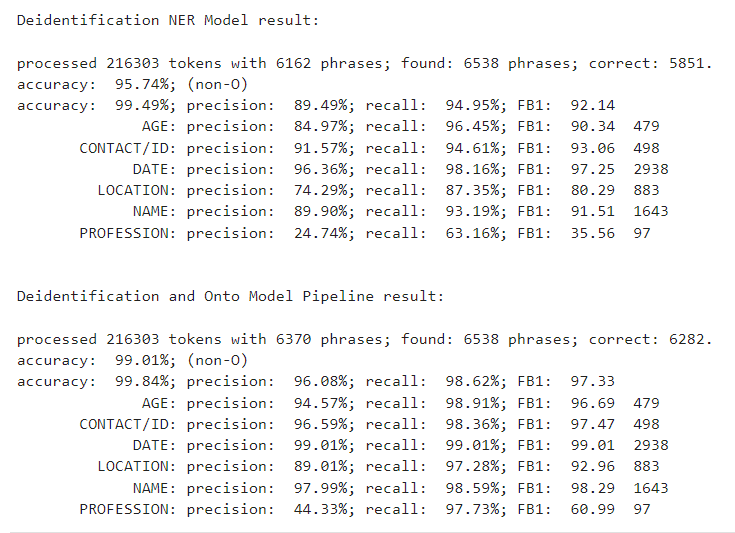

## Create Pipeline

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on n2c2 (de-identification and Heart Disease Risk Factors Challenge) datasets)
deid_ner_generic = medical.NerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_deid")

ner_converter_deid = medical.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_deid"])\
    .setOutputCol("ner_chunk_deid")

# deberta_v3_base_token_classifier_ontonotes
deid_ner_onto = nlp.DeBertaForTokenClassification.pretrained("deberta_v3_base_token_classifier_ontonotes", "en")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("ner_onto")\
    .setCaseSensitive(True)\
    .setMaxSentenceLength(512)

ner_converter_onto = medical.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_onto"])\
    .setOutputCol("ner_chunk_onto")\
    .setWhiteList(["DATE","LOC","PERSON","TIME"])\
    .setReplaceLabels({"LOC": "LOCATION",
                       "PERSON": "NAME",
                       "TIME": "DATE"})

chunk_merge = medical.ChunkMergeApproach()\
    .setInputCols("ner_chunk_onto","ner_chunk_deid")\
    .setOutputCol("deid_merged_chunk")\
    .setMergeOverlapping(True)\
    .setChunkPrecedence("field")

nlpPipeline = nlp.Pipeline(stages=[
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      deid_ner_generic,
      ner_converter_deid,
      deid_ner_onto,
      ner_converter_onto,
      chunk_merge
      ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

light_model = nlp.LightPipeline(model)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]
deberta_v3_base_token_classifier_ontonotes download started this may take some time.
Approximate size to download 594.3 MB
[OK!]


In [ ]:
# Downloading sample datasets.
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples_10.csv

In [ ]:
# mt_samples_df = spark.read.csv("mt_samples_10.csv", header=True)

mt_samples_df = spark.createDataFrame(pd.read_csv("./mt_samples_10.csv", sep=',', index_col=["index"]).reset_index())

In [ ]:
text = mt_samples_df.collect()[7]["text"]

text

"Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nMetastatic Ovarian Cancer - Consult\nDescription:\nA very pleasant 66-year-old woman with recurrent metastatic ovarian cancer.\n(Medical Transcription Sample Report)\nREASON FOR CONSULTATION:\nMetastatic ovarian cancer.\nHISTORY OF PRESENT ILLNESS:\nMrs. ABCD is a very nice 66-year-old woman who is followed in clinic by Dr. X for history of renal cell cancer, breast cancer, as well as ovarian cancer, which was initially diagnosed 10 years ago, but over the last several months has recurred and is now metastatic. She last saw Dr. X in clinic towards the beginning of this month. She has been receiving gemcitabine and carboplatin, and she receives three cycles of this with the last one being given on 12/15/08. She was last seen in clinic on 12/22/08 by Dr. Y. At that point, her white count was 0.9 with the hemoglobin of 10.3, hematocrit of 30%, and platelets of 81,000. Her ANC was 0.5. She was started on prophylactic A

## Compare results

In [ ]:
def get_df(light_result, chunk_col):

    chunks = []
    entities = []
    sentence= []
    begin = []
    end = []

    for n in light_result[0][chunk_col]:

        begin.append(n.begin)
        end.append(n.end)
        chunks.append(n.result)
        entities.append(n.metadata['entity'])
        sentence.append(n.metadata['sentence'])

    df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end,
                                'sentence_id':sentence, 'entities':entities})

    return df_clinical

In [ ]:
light_result = light_model.fullAnnotate(text)

In [ ]:
df_ner_deid_result = get_df(light_result, chunk_col = "ner_chunk_deid")
df_ner_onto_result = get_df(light_result, chunk_col = "ner_chunk_onto")
df_ner_merged_result = get_df(light_result, chunk_col = "deid_merged_chunk")

In [ ]:
from google.colab import widgets

t = widgets.TabBar(["deid_ner_generic", "deid_ner_onto", "deid_merged_ner"])

with t.output_to(0):
    display(df_ner_deid_result.head(20))

with t.output_to(1):
    display(df_ner_onto_result.head(20))

with t.output_to(2):
    display(df_ner_merged_result.head(25))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,begin,end,sentence_id,entities
0,66-year-old,133,143,3,AGE
1,66-year-old,336,346,7,AGE
2,12/15/08,767,774,9,DATE
3,12/22/08,808,815,10,DATE
4,Y,824,824,10,NAME
5,November,1148,1155,14,DATE
6,unit clerk,4341,4350,66,PROFESSION
7,XYZ Medical Center,4355,4372,66,LOCATION
8,12/25/08,7356,7363,114,DATE
9,November,7519,7526,114,DATE


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,begin,end,sentence_id,entities
0,66-year-old,133,143,3,DATE
1,ABCD,316,319,7,NAME
2,66-year-old,336,346,7,DATE
3,X,387,387,7,NAME
4,10 years ago,495,506,7,DATE
5,the last several months,518,540,7,DATE
6,Dr. X,591,595,8,NAME
7,the beginning of this month,615,641,8,DATE
8,12/15/08,767,774,9,DATE
9,12/22/08,808,815,10,DATE


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,begin,end,sentence_id,entities
0,66-year-old,133,143,3,DATE
1,ABCD,316,319,7,NAME
2,66-year-old,336,346,7,DATE
3,X,387,387,7,NAME
4,10 years ago,495,506,7,DATE
5,the last several months,518,540,7,DATE
6,Dr. X,591,595,8,NAME
7,the beginning of this month,615,641,8,DATE
8,12/15/08,767,774,9,DATE
9,12/22/08,808,815,10,DATE


<IPython.core.display.Javascript object>

In [ ]:
#from sparknlp_display import NerVisualizer

visualiser = nlp.viz.NerVisualizer()



t = widgets.TabBar(["deid_ner_generic", "deid_ner_onto", "deid_merged_ner"])

with t.output_to(0):
    visualiser.display(light_result[0], label_col='ner_chunk_deid', document_col='document')

with t.output_to(1):
    visualiser.display(light_result[0], label_col='ner_chunk_onto', document_col='document')

with t.output_to(2):
    visualiser.display(light_result[0], label_col='deid_merged_chunk', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

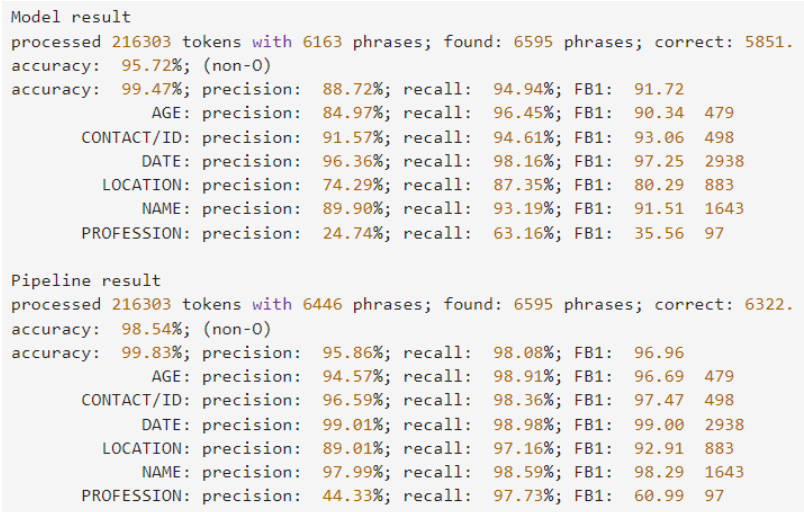